# LASSO Analysis
Lixun Zhang  
Dec 15, 2015

## 1 Introduction
### 1.1 About the method
LASSO, which stands for Least Absolute Shrinkage and Selection Operator, is one of the model complexity control techniques like variable selection and ridge regression. In this notebook we'll demonstrate how to use the *glmnet* package for LASSO regression. For more information about LASSO you can refer to the [LASSO Page][lasso link].

### 1.2 Target audience
This notebook is targeted toward data scientists who understand linear regression and want to find out how to fit LASSO regression in R. An operationalization step is also included to show how you can deploy in Azure a web service based on the selected model. 

## 2 Data
In this example, we'll use the housing data from the R package *MASS*. There are 506 rows and 14 columns in the dataset. Available information includes median home price, average number of rooms per dwelling, crime rate by town, etc. More information about this dataset can be found at [UCI][uci link] or by typing "help(Boston)" in an R terminal.

## 3 Analysis
For illustration purposes, we'll use "medv" - median home price - as the response variable and the remaining variables as predictors.

The first step in fitting LASSO regression is to determine the value of tuning parameter λ which controls the overall strength of the penalty. Here we'll use cross-validation to choose the λ that gives the least validation error.

[lasso link]: http://statweb.stanford.edu/~tibs/lasso.html
[uci link]: https://archive.ics.uci.edu/ml/datasets/Housing

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-2



[1] "Started fitting LASSO"
[1] "Finished fitting LASSO"


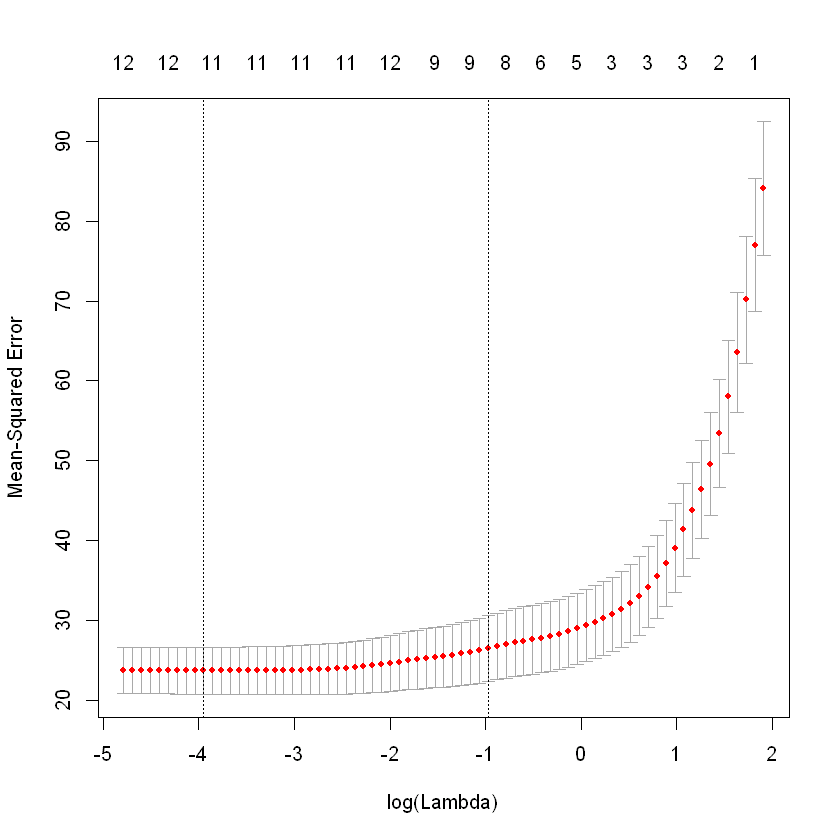

In [1]:
# show images inline
options(jupyter.plot_mimetypes = 'image/png')

# load libraries
library(glmnet)
library(MASS)

# define response variable and predictor variables
response_column <- which(colnames(Boston) %in% c("medv"))
train_X <- data.matrix(Boston[, -response_column])
train_y <- Boston[,response_column]

# use cv.glmnet with 10-fold cross-validation to pick lambda
print("Started fitting LASSO")
model1 <- cv.glmnet(x = train_X, y = train_y, alpha = 1, nfolds = 10, 
                    family = "gaussian", type.measure = "mse")
print("Finished fitting LASSO")
plot(model1)

In the above plot, the red dotted line shows the cross-validation error and the error bars show the uppper and lower standard deviation. The dotted vertical line to the left is for the optimal λ that gives minimum mean cross-validation error. The vertile line to the right is for the λ whose cross-validation error falls within one standard error of the minimum error. The number of nonzero coefficients for different λ is shown along the axis at the top. The values for λ and associated coefficients are printed below.

In [2]:
cat("Lambda that gives minimum mean cross-validated error:", 
            as.character(round(model1$lambda.min, 4)), "\n\n")
cat("Largest lambda with mean cross-validated error",
            "within 1 standard error of the minimum error:", 
            as.character(round(model1$lambda.1se, 4)), "\n\n")
cat("Coefficients based on lambda that gives minimum mean cross-validated error:")
print(coef(model1, s = "lambda.min"))

Lambda that gives minimum mean cross-validated error: 0.0193 

Largest lambda with mean cross-validated error within 1 standard error of the minimum error: 0.3789 

Coefficients based on lambda that gives minimum mean cross-validated error:14 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  35.009928169
crim         -0.101393480
zn            0.042784125
indus         .          
chas          2.696136603
nox         -16.634667961
rm            3.847231871
age           .          
dis          -1.425687466
rad           0.266888579
tax          -0.010418000
ptratio      -0.935038260
black         0.009107537
lstat        -0.522525376


While the model selected by cv.glmnet() can be used for making predictions, we also want to better understand how the values of λ impact the estimated coefficients. Such information can be produced by the glmnet() function. In the plot that's generated below, it can be observed that the coefficients shrink toward zero as the value of λ increases.

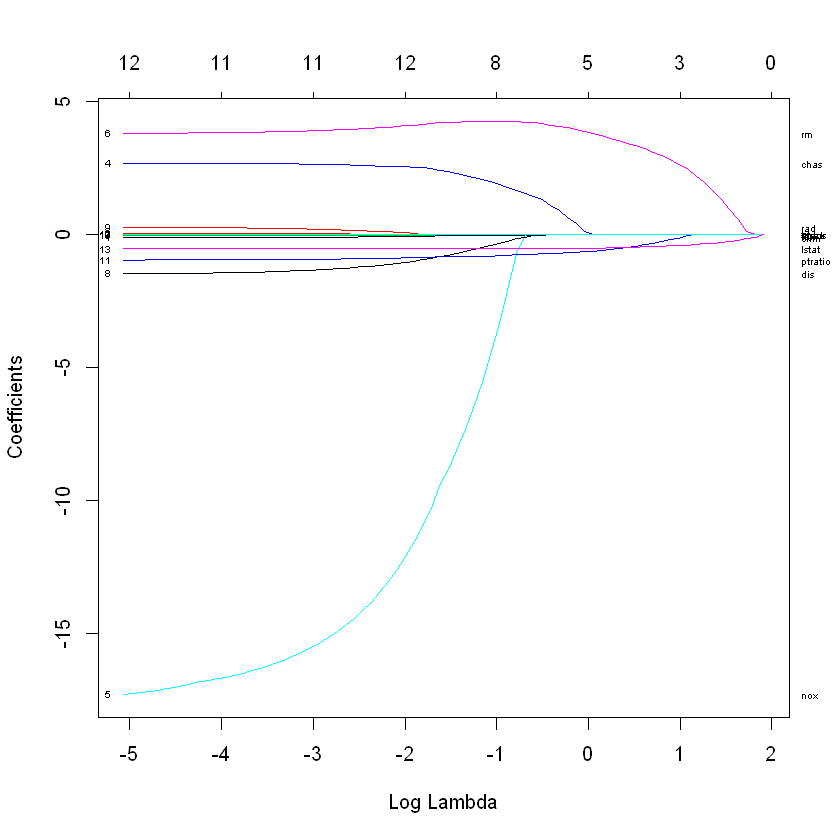

In [3]:
model2 <- glmnet(x = train_X, y = train_y, alpha = 1, family = "gaussian")
plot(model2, xvar = "lambda", label = TRUE)

# add labels for variables
vn = colnames(train_X)
par(mar = c(5, 4, 4, 2) + 0.1) 
vnat=coef(model2)
vnat=vnat[-1,ncol(vnat)] # remove the intercept, and get the coefficients at the end of the path
axis(4, at=vnat, line=-.5, label=vn, las=1, tick=FALSE, cex.axis=0.5) 

In [4]:
coef(model2)

   [[ suppressing 76 column names 's0', 's1', 's2' ... ]]
   [[ suppressing 76 column names 's0', 's1', 's2' ... ]]


14 x 76 sparse Matrix of class "dgCMatrix"
                                                                            
(Intercept) 22.53281 23.60072190 23.6726400 21.4464864 19.4205718 17.5746365
crim         .        .           .          .          .          .        
zn           .        .           .          .          .          .        
indus        .        .           .          .          .          .        
chas         .        .           .          .          .          .        
nox          .        .           .          .          .          .        
rm           .        .           0.1278413  0.5694424  0.9714620  1.3377669
age          .        .           .          .          .          .        
dis          .        .           .          .          .          .        
rad          .        .           .          .          .          .        
tax          .        .           .          .          .          .        
ptratio      .        .          

The coefficients from this model with the optimal λ are also printed below. As we would expect, they are the same as those from using cv.glmnet().

In [5]:
coef(model2, s = model1$lambda.min)

14 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  35.009928169
crim         -0.101393480
zn            0.042784125
indus         .          
chas          2.696136603
nox         -16.634667961
rm            3.847231871
age           .          
dis          -1.425687466
rad           0.266888579
tax          -0.010418000
ptratio      -0.935038260
black         0.009107537
lstat        -0.522525376

To make predictions, either of the two models can be used.

In [6]:
x_new <- data.matrix(train_X[1:2, -response_column])
predictions_train_lasso <- predict(model1, newx = x_new, s = "lambda.min")
print(predictions_train_lasso)
predictions_train_lasso2 <- predict(model2, newx = x_new, s = model1$lambda.min)
print(predictions_train_lasso2)

         1
1 30.18412
2 25.03488
         1
1 30.18412
2 25.03488


## 4 Web service
### 4.1 Deploy a web service
With the developed model, we can deploy a web service on Azure so that others can use it to make predictions. The "AzureML" package will be used for this purpose. You'll need to provide the work space ID and authorization token for an Azure machine learning workspace. More information about this can be found in the [Tutorial][tut link].

[tut link]: ???

In [7]:
# load the library
library(AzureML)

# workspace information
ws <- workspace(
  id = "b2bbeb56a1d04e1599d2510a06c59d87",
  auth = "a3978d933cd84e64ab583a616366d160"
)

# define predict function
mypredict <- function(newdata)
{
  require(glmnet)
  newdata <- data.matrix(newdata) # the prediction data need to be a matrix for glmnet
  res <- predict(model2, newx = newdata, s = model1$lambda.min)
  res
}

# test the prediction function
newdata <- Boston[1, 1:13]
print(newdata)
mypredict(newdata)

# deploy the service
ep <- publishWebService(ws = ws, fun = mypredict, 
                        name = "LASSOPrediction", 
                        inputSchema = newdata, 
                        outputSchema = list(ans = "numeric"))

     crim zn indus chas   nox    rm  age  dis rad tax ptratio black lstat
1 0.00632 18  2.31    0 0.538 6.575 65.2 4.09   1 296    15.3 396.9  4.98


,1
1,30.18412


### 4.2 Consume a web service
The [Tutorial][tut link] describes three ways of consuming the web service and we'll use one of those approaches here.

[tut link]: ???

In [8]:
# retrieve web service information
service_id <- ep$WebServiceId
ep_price_pred <- endpoints(ws, service_id)

# print(service_id)
# print(ep_price_pred)

In [9]:
# consume
consume(ep_price_pred, newdata)

Request failed with status 401. Retrying request...


,ans
1,30.18412


## 5 Conclusion
Using the Boston housing dataset, we demonstrated how to carry out LASSO regression analysis. We started the analysis by determining the optimal value of the tuning parameter λ using cross-validation. Then we examined the impact of λ on the coefficient estimates. A web service was deployed based on the selected model.

---  
Created by a Microsoft Employee.  
Copyright © Microsoft. All Rights Reserved.